<a href="https://colab.research.google.com/github/YuxuanLiu0622/ECE50024-Project-Team15/blob/main/checkpoint3_baseline_upload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint 3: Reimplementation of Learning to Reweight Examples for Robust Deep Learning on Toy Problems (FashionMNIST) Part 1: standard CNN without reweighting

**Team15: Hyun Soo Park, Andres Martinez, Heesoo Kim, Mingyu Kim, Yuxuan Liu**

In [ ]:
!pip install tqdm
!pip install higher
import time
from typing import List, Dict
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy
from tqdm import tqdm
import IPython
import higher

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def set_seed(seed: int = 0) -> None:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(0)


We build a standard CNN consisting of four layers with increasing channels, followed by ReLU and max pooling for binary classfication.

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv = nn.Conv2d(1, 8, kernel_size=3)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
    self.conv3 = nn.Conv2d(16,32,kernel_size=3)
    self.conv4 = nn.Conv2d(32,32,kernel_size=3)
    self.fc = nn.Linear(512, 1)

  def forward(self, x):
    x = self.conv(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.relu(F.max_pool2d(x,2))
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.relu(F.max_pool2d(x,2))
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

We target the classification of "sneakers" (class 7) and "ankle boots" (class 9) in FashionMNist dataset.

In [ ]:
train_fmnist = torchvision.datasets.FashionMNIST(root="data", train=True, download=True,transform=transform)
test_fmnist = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,transform=transform)
val_fmnist = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,transform=transform)

In [ ]:
def split_dataset(class1: int, class2: int, imbalance_ratio: float, n_samples: int, train_dataset: torchvision.datasets) -> torch.utils.data.Dataset:
    new_data = train_dataset
    n_class1 = int(imbalance_ratio*n_samples)
    n_class2 = n_samples - n_class1
    class1_indices = (train_dataset.targets == class1).nonzero().squeeze()
    class2_indices = (train_dataset.targets == class2).nonzero().squeeze()

    selected_class1_indices = class1_indices[torch.randperm(class1_indices.size(0))[:n_class1]]
    selected_class2_indices = class2_indices[torch.randperm(class2_indices.size(0))[:n_class2]]

    new_data.data = torch.cat((train_dataset.data[selected_class1_indices], train_dataset.data[selected_class2_indices]))

    new_data.targets = torch.cat((torch.zeros(selected_class1_indices.size()), torch.ones(selected_class2_indices.size())))

    return new_data

The training set is given an imbalanced proportion of 99.5%. The validation and testing set is equally distributed.

In [ ]:
train_set = split_dataset(7,9,0.9,5000,train_fmnist)
test_set = split_dataset(7,9,0.5,100,test_fmnist)
val_set = split_dataset(7,9,0.5,10,val_fmnist)

In [ ]:
hyperparameters = {
    'lr' : 1e-3,
    'momentum' : 0.9,
    'batch_size' : 128,
    'epoch' : 5000,
}

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size = hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=hyperparameters['batch_size'], shuffle=False)

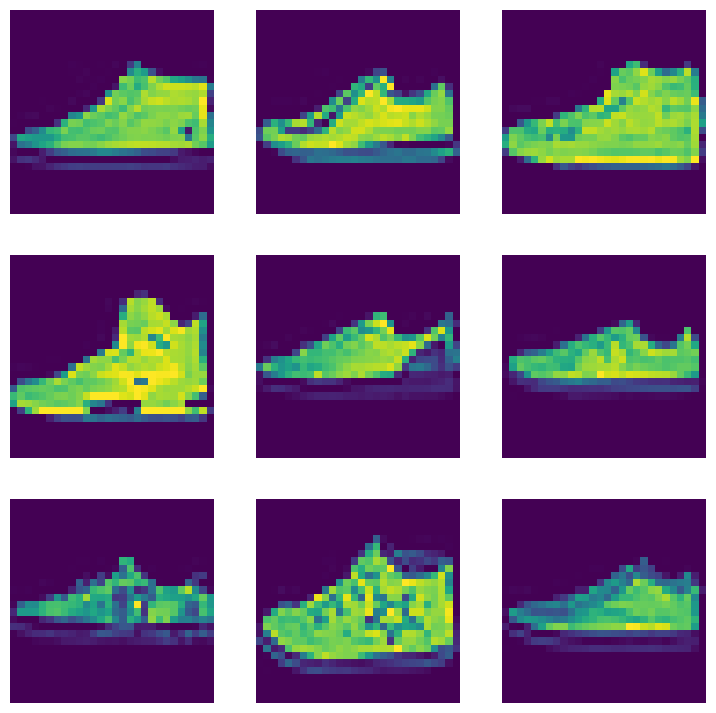

In [ ]:
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()

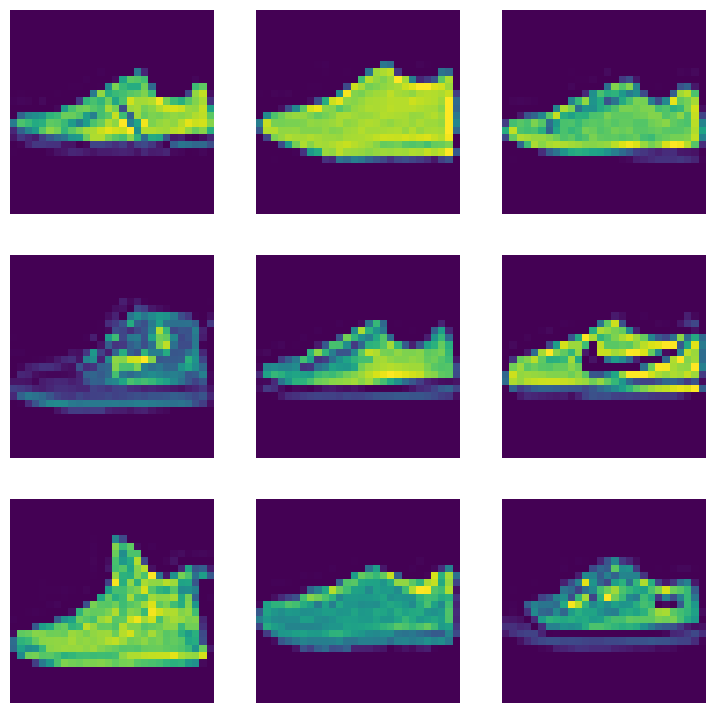

In [ ]:
batch_idx, (images, targets) = next(enumerate(test_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()

## Base model using CNN

In [ ]:
model = CNN().to(device)
optimizer = optim.SGD((model).parameters(), lr=hyperparameters['lr'])
running_loss = 0
running_losses = []
step = 500

accuracy_log = []
for i in tqdm(range(hyperparameters['epoch'])):
  model.train()

  image, labels = next(iter(train_loader))

  image = image.to(device)
  labels = labels.to(device)

  y = model(image)
  y = y.squeeze()
  loss = F.binary_cross_entropy_with_logits(y, labels.float())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  running_loss += loss.item()
  running_losses.append(running_loss / (i + 1))  # Average loss per batch


  if i % step == 0:
    model.eval()
    accuracies = []  # To store accuracy of each example
    with torch.no_grad():
        for idx, (test_image, test_labels) in enumerate(test_loader):
            test_image = test_image.to(device)
            test_labels = test_labels.to(device)

            output = model(test_image).squeeze()
            pred = (torch.sigmoid(output) > 0.5).int()

            # Calculate accuracy as a flat tensor for each example
            batch_accuracy = (pred == test_labels.int()).float()
            accuracies.append(batch_accuracy)

        # Concatenate all batch accuracies to calculate overall accuracy
        all_accuracies = torch.cat(accuracies, dim=0)
        overall_accuracy = all_accuracies.mean().item()  # Convert to Python number for logging
        print(overall_accuracy)

    accuracy_log.append(np.array([i, overall_accuracy])[None])

  0%|          | 3/5000 [00:00<17:17,  4.81it/s]

0.2770000100135803


 10%|█         | 502/5000 [00:56<20:47,  3.61it/s]

0.5


 20%|██        | 1003/5000 [01:53<09:49,  6.78it/s]

0.5


 30%|███       | 1502/5000 [02:49<15:14,  3.82it/s]

0.5


 40%|████      | 2003/5000 [03:46<07:16,  6.87it/s]

0.5


 50%|█████     | 2502/5000 [04:43<11:21,  3.66it/s]

0.5


 60%|██████    | 3002/5000 [05:41<07:29,  4.45it/s]

0.5


 70%|███████   | 3503/5000 [06:38<05:53,  4.23it/s]

0.5


 80%|████████  | 4002/5000 [07:39<04:14,  3.92it/s]

0.5


 90%|█████████ | 4502/5000 [08:36<01:32,  5.36it/s]

0.5


100%|██████████| 5000/5000 [09:38<00:00,  8.65it/s]


Text(0.5, 0, 'Iteration')

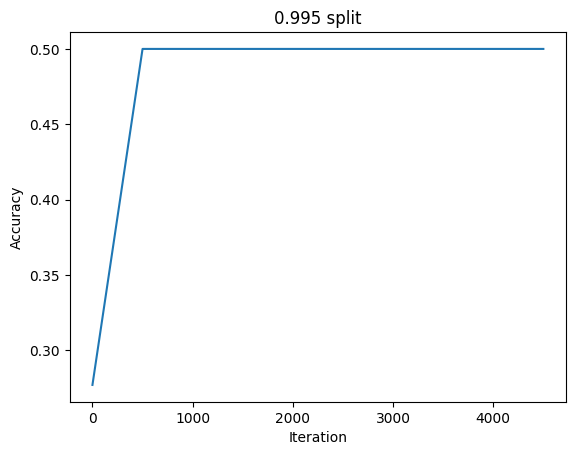

In [ ]:
acc_log = np.concatenate(accuracy_log, axis=0)
plt.plot(acc_log[:,0],acc_log[:,1])
plt.title('0.995 split')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')